In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np

import tensorflow.keras

import os
from glob import glob

import timeit

from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import datetime

import pandas as pd

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Define the model

In [1]:
from Model import make_KaI

In [4]:
img_height = 128
img_width = 128
nclasses=2
filters=16
one_hot=1

KaI = make_KaI(img_height, img_width, nclasses, filters, one_hot)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Plot the Model

Using TensorFlow backend.


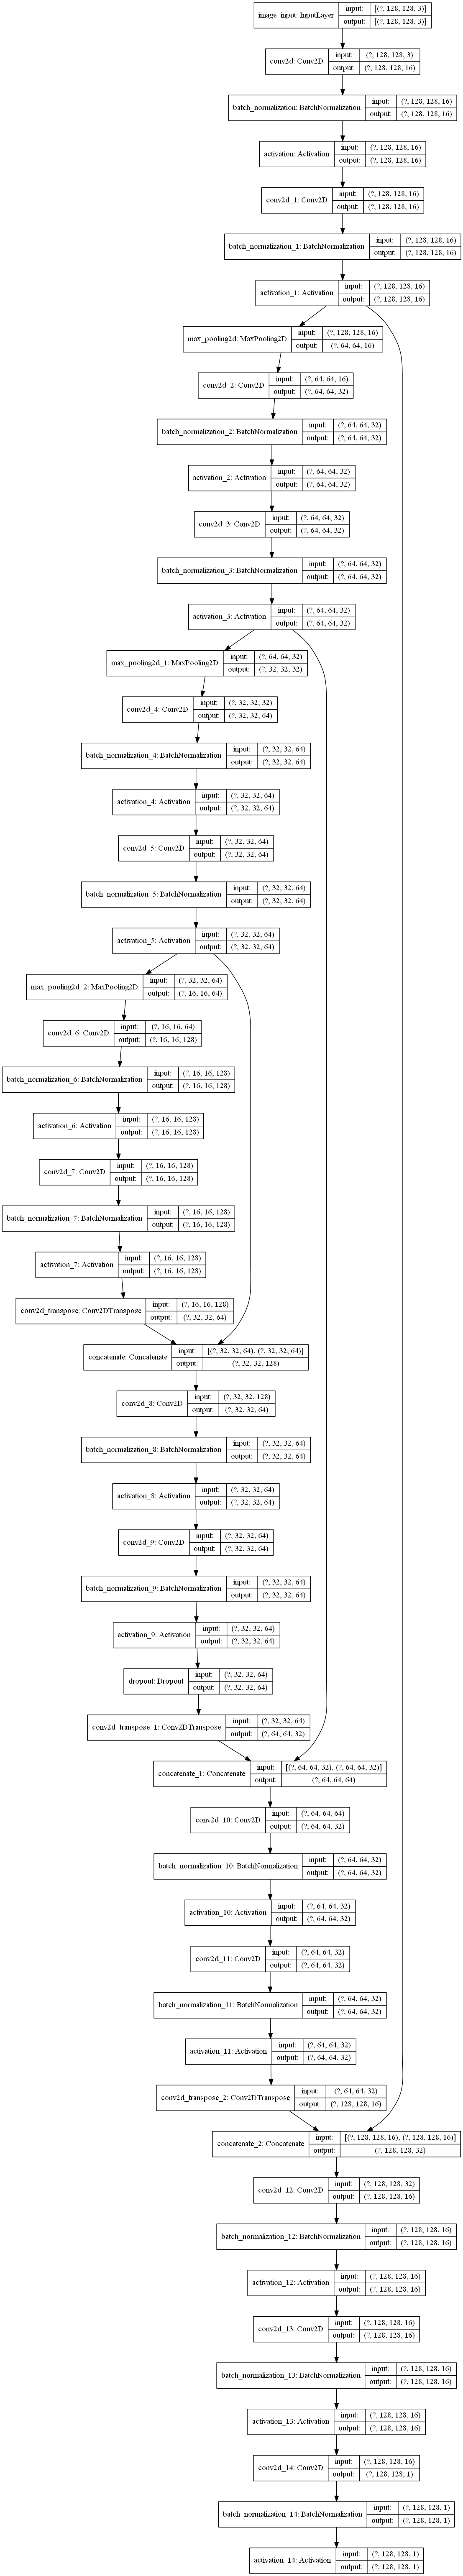

In [5]:
import pydotplus
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
tf.keras.utils.plot_model(KaI, to_file="D:/Masterarbeit/Data/model_full_KaI_not_one_hot_deep.png", show_shapes=True)

## Loading the data: Custom Generator

In [6]:
from Data import image_generator

In [7]:
files_mask_train = glob("D:\\Masterarbeit\\Data\\raw_terrain_data\\tf_data\\train\\WOKAM\\subfolder\\*")
files_img_train = glob("D:\\Masterarbeit\\Data\\raw_terrain_data\\tf_data\\train\\SRTM\\subfolder\\*")

files_mask_test = glob("D:\\Masterarbeit\\Data\\raw_terrain_data\\tf_data\\test\\WOKAM\\subfolder\\*")
files_img_test = glob("D:\\Masterarbeit\\Data\\raw_terrain_data\\tf_data\\test\\SRTM\\subfolder\\*")

In [8]:
train_generator = image_generator(files_img_train, files_mask_train, batch_size = 64, intensify = False, random = True, categorical = False)
test_generator = image_generator(files_img_test, files_mask_test, batch_size = 64, intensify = False, random = False, categorical = False)

In [8]:
train_generator_10 = image_generator(files_img_train, files_mask_train, batch_size = 64, intensify = 10, random = True)
test_generator_10 = image_generator(files_img_test, files_mask_test, batch_size = 64, intensify = 10, random = False)

In [9]:
train_generator_20 = image_generator(files_img_train, files_mask_train, batch_size = 64, intensify = 20, random = True)
test_generator_20 = image_generator(files_img_test, files_mask_test, batch_size = 64, intensify = 20, random = False)

In [7]:
train_generator_50 = image_generator(files_img_train, files_mask_train, batch_size = 64, intensify = 50, random = True)
test_generator_50 = image_generator(files_img_test, files_mask_test, batch_size = 64, intensify = 50, random = False)

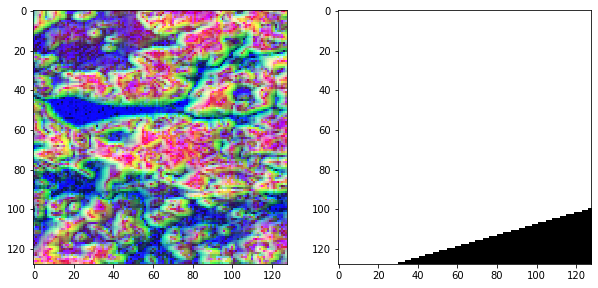

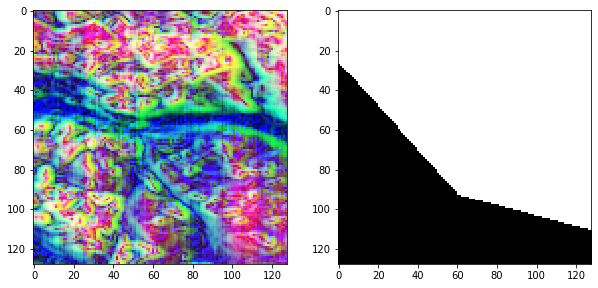

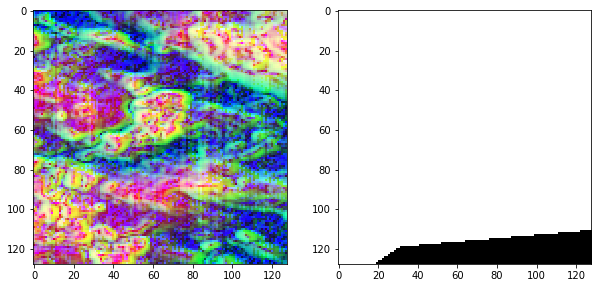

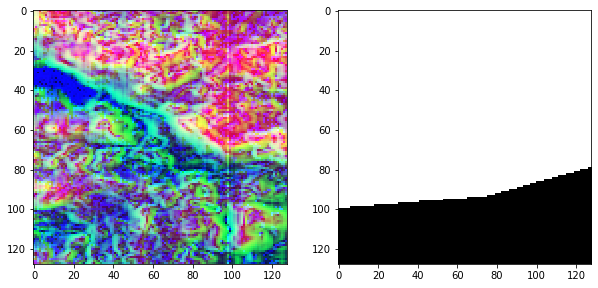

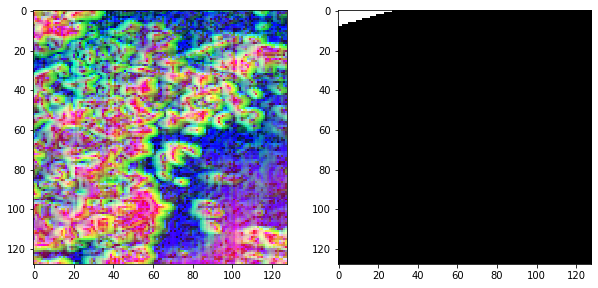

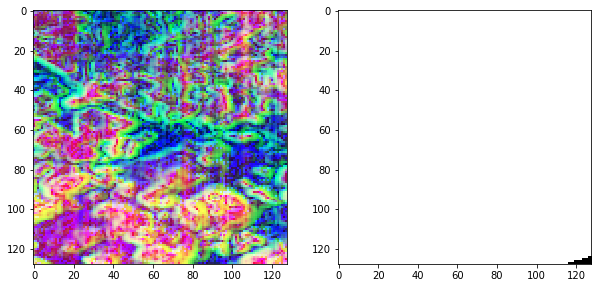

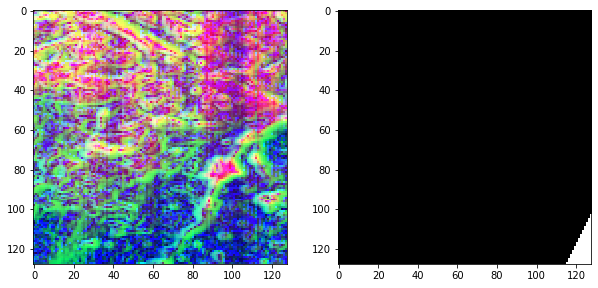

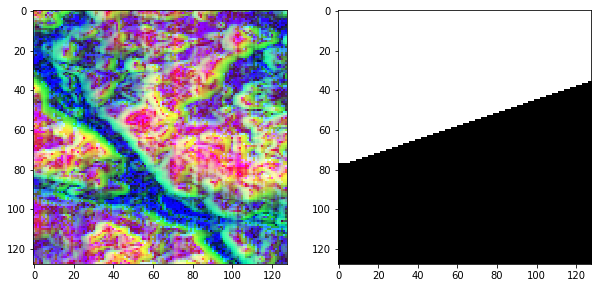

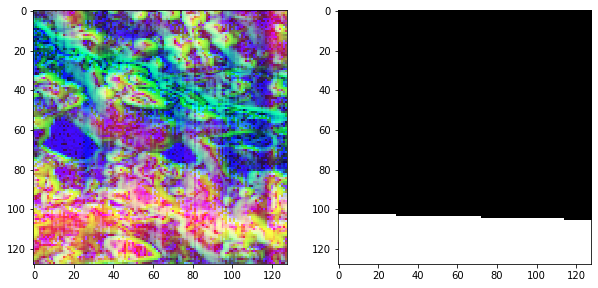

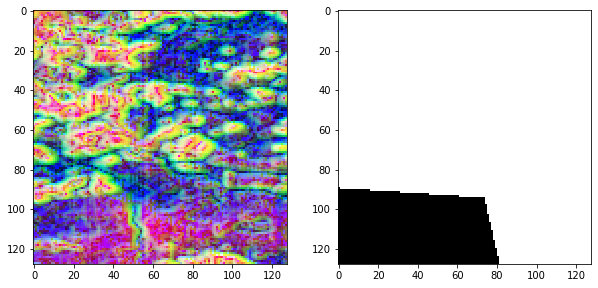

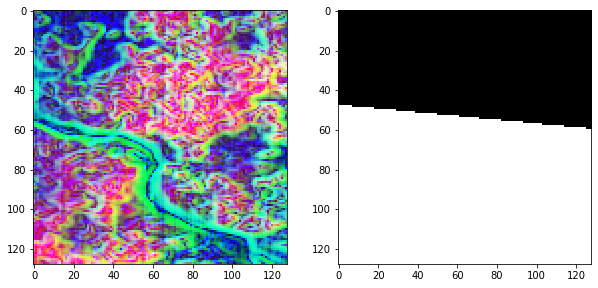

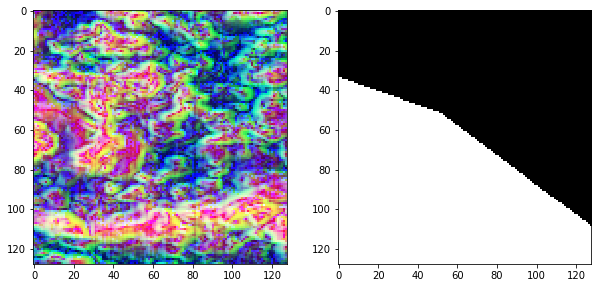

In [9]:
for i in range(0,12):
    
    x, y = next(test_generator)
    image = x[i]
    mask = y[i].reshape(128,128)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    ax1.imshow(image)
    ax2.imshow(mask, cmap = "Greys")
    
    plt.show()

## Train the Model

In [8]:
def custom_loss(y_true, y_pred):
    return tf.losses.sigmoid_cross_entropy(y_true, y_pred, label_smoothing=0.1)

In [14]:
class_weights = np.zeros((128,128, 2))
class_weights[:,:, 0] += 0.5
class_weights[:,:, 1] += 2

In [10]:
#adam = tf.keras.optimizers.Adam(lr=0.0001)
adam = tf.keras.optimizers.Adam(lr=0.001)

In [19]:
def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice


In [11]:
KaI.compile(optimizer= adam, loss= ['binary_crossentropy'] , metrics=['binary_accuracy', "mse"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
batch_size = 64

In [16]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_categorical_cross"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_blank_categorical_cross.h5', monitor='val_binary_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history = KaI.fit_generator(
train_generator,
steps_per_epoch=len(files_mask_test) // batch_size,
epochs= 100,
validation_data= test_generator,
validation_steps=len(files_mask_test) // batch_size , 
callbacks=callbacks,
class_weight = class_weights
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_categorical_cross.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Epoch 1/100
27/27 [==============================] - 113s 4s/step - loss: 7.0766 - binary_accuracy: 0.6155 - mean_squared_error: 0.3827

Epoch 00001: val_binary_accuracy improved from -inf to 0.61551, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_blank_categorical_cross.h5
27/27 [==============================] - 273s 10s/step - loss: 0.5022 - binary_accuracy: 0.8298 - mean_squared_error: 0.1399 - val_loss: 7.0766 - val_binary_accuracy: 0.6155 - val_mean_squared_error: 0.3827
Epoch 2/100
27/27 [==============================] - 160s 6s/step - loss: 41.9772 - binary_accuracy: 0.5589 - mean_squared_error: 0.4411

Epoch 00002: val_binary_accuracy did not improve from 0.61551
27/27 [==============================] - 225s 8s/step - loss: 0.6726 - binary_accuracy: 0.6165 - mean_squared_error: 0.2340 - val_loss: 41.9772 - val_binary_accuracy: 0.5589 - val_mean_squared_error: 0.4411
Epoch 3/100
27/27 [==============================] - 161s 6s/step - loss: 1.3825 - binary_accu

27/27 [==============================] - 78s 3s/step - loss: 1.3736 - binary_accuracy: 0.3942 - mean_squared_error: 0.4479

Epoch 00031: val_binary_accuracy did not improve from 0.61555
27/27 [==============================] - 191s 7s/step - loss: 0.6069 - binary_accuracy: 0.6861 - mean_squared_error: 0.2044 - val_loss: 1.3736 - val_binary_accuracy: 0.3942 - val_mean_squared_error: 0.4479
Epoch 32/100
27/27 [==============================] - 213s 8s/step - loss: 1.0161 - binary_accuracy: 0.4332 - mean_squared_error: 0.3657

Epoch 00032: val_binary_accuracy did not improve from 0.61555
27/27 [==============================] - 345s 13s/step - loss: 0.6024 - binary_accuracy: 0.7352 - mean_squared_error: 0.1859 - val_loss: 1.0161 - val_binary_accuracy: 0.4332 - val_mean_squared_error: 0.3657
Epoch 33/100
27/27 [==============================] - 110s 4s/step - loss: 0.8740 - binary_accuracy: 0.4424 - mean_squared_error: 0.3310

Epoch 00033: val_binary_accuracy did not improve from 0.61555
2

27/27 [==============================] - 143s 5s/step - loss: 0.8233 - binary_accuracy: 0.4331 - mean_squared_error: 0.3040

Epoch 00061: val_binary_accuracy did not improve from 0.62174
27/27 [==============================] - 206s 8s/step - loss: 0.6519 - binary_accuracy: 0.6766 - mean_squared_error: 0.2101 - val_loss: 0.8233 - val_binary_accuracy: 0.4331 - val_mean_squared_error: 0.3040
Epoch 62/100
27/27 [==============================] - 163s 6s/step - loss: 0.8954 - binary_accuracy: 0.4015 - mean_squared_error: 0.3372

Epoch 00062: val_binary_accuracy did not improve from 0.62174
27/27 [==============================] - 292s 11s/step - loss: 0.6109 - binary_accuracy: 0.6745 - mean_squared_error: 0.2118 - val_loss: 0.8954 - val_binary_accuracy: 0.4015 - val_mean_squared_error: 0.3372
Epoch 63/100
27/27 [==============================] - 78s 3s/step - loss: 0.7046 - binary_accuracy: 0.5664 - mean_squared_error: 0.2622

Epoch 00063: val_binary_accuracy did not improve from 0.62174
2

Epoch 77/100
27/27 [==============================] - 138s 5s/step - loss: 0.7294 - binary_accuracy: 0.5365 - mean_squared_error: 0.2653

Epoch 00077: val_binary_accuracy did not improve from 0.62174
27/27 [==============================] - 274s 10s/step - loss: 0.6187 - binary_accuracy: 0.6954 - mean_squared_error: 0.1989 - val_loss: 0.7294 - val_binary_accuracy: 0.5365 - val_mean_squared_error: 0.2653
Epoch 78/100
27/27 [==============================] - 109s 4s/step - loss: 0.8395 - binary_accuracy: 0.5216 - mean_squared_error: 0.2950

Epoch 00078: val_binary_accuracy did not improve from 0.62174
27/27 [==============================] - 185s 7s/step - loss: 0.6209 - binary_accuracy: 0.6728 - mean_squared_error: 0.2142 - val_loss: 0.8395 - val_binary_accuracy: 0.5216 - val_mean_squared_error: 0.2950
Epoch 79/100
27/27 [==============================] - 184s 7s/step - loss: 0.7749 - binary_accuracy: 0.5251 - mean_squared_error: 0.2836

Epoch 00079: val_binary_accuracy did not improve 

In [20]:
KaI.compile(optimizer= adam, loss= [dice_coe] , metrics=['binary_accuracy'])

In [22]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_dice"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_blank_dice.h5', monitor='val_binary_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history = KaI.fit_generator(
train_generator,
steps_per_epoch=len(files_mask_test) // batch_size,
epochs= 100,
validation_data= test_generator,
validation_steps=len(files_mask_test) // batch_size , 
callbacks=callbacks
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_dice.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Epoch 1/100
27/27 [==============================] - 346s 13s/step - loss: 0.3268 - binary_accuracy: 0.5378

Epoch 00001: val_binary_accuracy improved from -inf to 0.53776, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_blank_dice.h5
27/27 [==============================] - 452s 17s/step - loss: 0.3194 - binary_accuracy: 0.3728 - val_loss: 0.3268 - val_binary_accuracy: 0.5378
Epoch 2/100
27/27 [==============================] - 157s 6s/step - loss: 0.2591 - binary_accuracy: 0.6037

Epoch 00002: val_binary_accuracy improved from 0.53776 to 0.60370, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_blank_dice.h5
27/27 [==============================] - 257s 10s/step - loss: 0.2485 - binary_accuracy: 0.3692 - val_loss: 0.2591 - val_binary_accuracy: 0.6037
Epoch 3/100
27/27 [==============================] - 343s 13s/step - loss: 0.3990 - binary_accuracy: 0.5590

Epoch 00003: val_binary_accuracy did not improve from 0.60370
27/27 [============================

Epoch 20/100
27/27 [==============================] - 319s 12s/step - loss: 0.3216 - binary_accuracy: 0.5128

Epoch 00020: val_binary_accuracy did not improve from 0.61268
27/27 [==============================] - 427s 16s/step - loss: 0.2370 - binary_accuracy: 0.4108 - val_loss: 0.3216 - val_binary_accuracy: 0.5128
Epoch 21/100
27/27 [==============================] - 321s 12s/step - loss: 0.2621 - binary_accuracy: 0.5539

Epoch 00021: val_binary_accuracy did not improve from 0.61268
27/27 [==============================] - 432s 16s/step - loss: 0.2386 - binary_accuracy: 0.4075 - val_loss: 0.2621 - val_binary_accuracy: 0.5539
Epoch 22/100
27/27 [==============================] - 185s 7s/step - loss: 0.2652 - binary_accuracy: 0.5740

Epoch 00022: val_binary_accuracy did not improve from 0.61268
27/27 [==============================] - 342s 13s/step - loss: 0.1945 - binary_accuracy: 0.4026 - val_loss: 0.2652 - val_binary_accuracy: 0.5740
Epoch 23/100
27/27 [==============================

Epoch 59/100
27/27 [==============================] - 184s 7s/step - loss: 0.1521 - binary_accuracy: 0.5803

Epoch 00059: val_binary_accuracy did not improve from 0.62102
27/27 [==============================] - 293s 11s/step - loss: 0.0943 - binary_accuracy: 0.4628 - val_loss: 0.1521 - val_binary_accuracy: 0.5803
Epoch 60/100
27/27 [==============================] - 349s 13s/step - loss: 0.1036 - binary_accuracy: 0.5732

Epoch 00060: val_binary_accuracy did not improve from 0.62102
27/27 [==============================] - 485s 18s/step - loss: 0.0976 - binary_accuracy: 0.4762 - val_loss: 0.1036 - val_binary_accuracy: 0.5732
Epoch 61/100
27/27 [==============================] - 170s 6s/step - loss: 0.2636 - binary_accuracy: 0.5867

Epoch 00061: val_binary_accuracy did not improve from 0.62102
27/27 [==============================] - 245s 9s/step - loss: 0.1155 - binary_accuracy: 0.4990 - val_loss: 0.2636 - val_binary_accuracy: 0.5867
Epoch 62/100
27/27 [==============================] 

Epoch 98/100
27/27 [==============================] - 155s 6s/step - loss: 0.1008 - binary_accuracy: 0.6165

Epoch 00098: val_binary_accuracy did not improve from 0.62227
27/27 [==============================] - 282s 10s/step - loss: 0.0774 - binary_accuracy: 0.4242 - val_loss: 0.1008 - val_binary_accuracy: 0.6165
Epoch 99/100
27/27 [==============================] - 332s 12s/step - loss: 0.0746 - binary_accuracy: 0.5603

Epoch 00099: val_binary_accuracy did not improve from 0.62227
27/27 [==============================] - 414s 15s/step - loss: 0.0655 - binary_accuracy: 0.4656 - val_loss: 0.0746 - val_binary_accuracy: 0.5603
Epoch 100/100
27/27 [==============================] - 237s 9s/step - loss: 0.0635 - binary_accuracy: 0.6094

Epoch 00100: val_binary_accuracy did not improve from 0.62227
27/27 [==============================] - 410s 15s/step - loss: 0.0618 - binary_accuracy: 0.4611 - val_loss: 0.0635 - val_binary_accuracy: 0.6094
10:32:57.370259


In [18]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "augment_10"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_augment_10.h5', monitor='val_categorical_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history_10 = KaI.fit_generator(
train_generator_10,
steps_per_epoch=len(files_mask_test) //  batch_size,
epochs= 100,
validation_data= test_generator_10,
validation_steps=len(files_mask_test) //  batch_size , 
callbacks=callbacks
#class_weight = class_weights
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_10.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_10.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Epoch 1/100
27/27 [==============================] - 93s 3s/step - loss: 0.6775 - categorical_accuracy: 0.6807

Epoch 00001: val_categorical_accuracy improved from -inf to 0.68069, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_10
27/27 [==============================] - 136s 5s/step - loss: 0.6860 - categorical_accuracy: 0.6671 - val_loss: 0.6775 - val_categorical_accuracy: 0.6807
Epoch 2/100
27/27 [==============================] - 114s 4s/step - loss: 0.6752 - categorical_accuracy: 0.6400

Epoch 00002: val_categorical_accuracy did not improve from 0.68069
27/27 [==============================] - 234s 9s/step - loss: 0.6826 - categorical_accuracy: 0.6859 - val_loss: 0.6752 - val_categorical_accuracy: 0.6400
Epoch 3/100
27/27 [==============================] - 130s 5s/step - loss: 0.7022 - categorical_accuracy: 0.6096

Epoch 00003: val_categorical_accuracy did not improve from 0.68069
27/27 [==============================] - 211s 8s/step - loss: 0.6877 - categ

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:83: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.1)))


27/27 [==============================] - 132s 5s/step - loss: 0.6721 - categorical_accuracy: 0.7007

Epoch 00012: val_categorical_accuracy did not improve from 0.72464
27/27 [==============================] - 272s 10s/step - loss: 0.6729 - categorical_accuracy: 0.7107 - val_loss: 0.6721 - val_categorical_accuracy: 0.7007
Epoch 13/100
27/27 [==============================] - 118s 4s/step - loss: 0.7003 - categorical_accuracy: 0.5856

Epoch 00013: val_categorical_accuracy did not improve from 0.72464
27/27 [==============================] - 171s 6s/step - loss: 0.6678 - categorical_accuracy: 0.7295 - val_loss: 0.7003 - val_categorical_accuracy: 0.5856
Epoch 14/100
27/27 [==============================] - 78s 3s/step - loss: 0.7103 - categorical_accuracy: 0.5352

Epoch 00014: val_categorical_accuracy did not improve from 0.72464
27/27 [==============================] - 208s 8s/step - loss: 0.6612 - categorical_accuracy: 0.7588 - val_loss: 0.7103 - val_categorical_accuracy: 0.5352
Epoch 15

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))


27/27 [==============================] - 144s 5s/step - loss: 0.6876 - categorical_accuracy: 0.6570

Epoch 00025: val_categorical_accuracy did not improve from 0.72464
27/27 [==============================] - 208s 8s/step - loss: 0.6642 - categorical_accuracy: 0.7515 - val_loss: 0.6876 - val_categorical_accuracy: 0.6570
Epoch 26/100
27/27 [==============================] - 58s 2s/step - loss: 0.6765 - categorical_accuracy: 0.7125

Epoch 00026: val_categorical_accuracy did not improve from 0.72464
27/27 [==============================] - 200s 7s/step - loss: 0.6666 - categorical_accuracy: 0.7386 - val_loss: 0.6765 - val_categorical_accuracy: 0.7125
Epoch 27/100
27/27 [==============================] - 158s 6s/step - loss: 0.6749 - categorical_accuracy: 0.6897

Epoch 00027: val_categorical_accuracy did not improve from 0.72464
27/27 [==============================] - 207s 8s/step - loss: 0.6606 - categorical_accuracy: 0.7737 - val_loss: 0.6749 - val_categorical_accuracy: 0.6897
Epoch 28/

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:83: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.1)))


27/27 [==============================] - 122s 5s/step - loss: 0.6672 - categorical_accuracy: 0.7092

Epoch 00039: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 170s 6s/step - loss: 0.6510 - categorical_accuracy: 0.7890 - val_loss: 0.6672 - val_categorical_accuracy: 0.7092
Epoch 40/100
27/27 [==============================] - 123s 5s/step - loss: 0.6676 - categorical_accuracy: 0.7319

Epoch 00040: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 248s 9s/step - loss: 0.6470 - categorical_accuracy: 0.7992 - val_loss: 0.6676 - val_categorical_accuracy: 0.7319
Epoch 41/100
27/27 [==============================] - 70s 3s/step - loss: 0.7235 - categorical_accuracy: 0.5310

Epoch 00041: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 143s 5s/step - loss: 0.6586 - categorical_accuracy: 0.7751 - val_loss: 0.7235 - val_categorical_accuracy: 0.5310
Epoch 42/

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:83: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.1)))


27/27 [==============================] - 163s 6s/step - loss: 0.6861 - categorical_accuracy: 0.6421

Epoch 00042: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 259s 10s/step - loss: 0.6515 - categorical_accuracy: 0.7788 - val_loss: 0.6861 - val_categorical_accuracy: 0.6421
Epoch 43/100
 8/27 [=======>......................] - ETA: 1:42 - loss: 0.6485 - categorical_accuracy: 0.7911

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:83: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.1)))


27/27 [==============================] - 78s 3s/step - loss: 0.7087 - categorical_accuracy: 0.5570

Epoch 00043: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 189s 7s/step - loss: 0.6551 - categorical_accuracy: 0.7933 - val_loss: 0.7087 - val_categorical_accuracy: 0.5570
Epoch 44/100
27/27 [==============================] - 132s 5s/step - loss: 0.6858 - categorical_accuracy: 0.6445

Epoch 00044: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 199s 7s/step - loss: 0.6359 - categorical_accuracy: 0.8522 - val_loss: 0.6858 - val_categorical_accuracy: 0.6445
Epoch 45/100
27/27 [==============================] - 117s 4s/step - loss: 0.6870 - categorical_accuracy: 0.6447

Epoch 00045: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 261s 10s/step - loss: 0.6346 - categorical_accuracy: 0.8506 - val_loss: 0.6870 - val_categorical_accuracy: 0.6447
Epoch 46

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:83: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.1)))


27/27 [==============================] - 71s 3s/step - loss: 0.7002 - categorical_accuracy: 0.5953

Epoch 00048: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 155s 6s/step - loss: 0.6620 - categorical_accuracy: 0.7003 - val_loss: 0.7002 - val_categorical_accuracy: 0.5953
Epoch 49/100
27/27 [==============================] - 140s 5s/step - loss: 0.6686 - categorical_accuracy: 0.6875

Epoch 00049: val_categorical_accuracy did not improve from 0.74295
27/27 [==============================] - 228s 8s/step - loss: 0.6555 - categorical_accuracy: 0.7689 - val_loss: 0.6686 - val_categorical_accuracy: 0.6875
Epoch 50/100
22/27 [=======================>......] - ETA: 27s - loss: 0.6470 - categorical_accuracy: 0.7978

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:83: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.1)))


27/27 [==============================] - 110s 4s/step - loss: 0.6577 - categorical_accuracy: 0.7521

Epoch 00050: val_categorical_accuracy improved from 0.74295 to 0.75211, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_10
27/27 [==============================] - 234s 9s/step - loss: 0.6448 - categorical_accuracy: 0.7986 - val_loss: 0.6577 - val_categorical_accuracy: 0.7521
Epoch 51/100
27/27 [==============================] - 87s 3s/step - loss: 0.6576 - categorical_accuracy: 0.7124

Epoch 00051: val_categorical_accuracy did not improve from 0.75211
27/27 [==============================] - 145s 5s/step - loss: 0.6479 - categorical_accuracy: 0.7932 - val_loss: 0.6576 - val_categorical_accuracy: 0.7124
Epoch 52/100
16/27 [================>.............] - ETA: 48s - loss: 0.6493 - categorical_accuracy: 0.7900

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))


27/27 [==============================] - 149s 6s/step - loss: 0.6702 - categorical_accuracy: 0.7071

Epoch 00052: val_categorical_accuracy did not improve from 0.75211
27/27 [==============================] - 285s 11s/step - loss: 0.6506 - categorical_accuracy: 0.7840 - val_loss: 0.6702 - val_categorical_accuracy: 0.7071
Epoch 53/100
27/27 [==============================] - 64s 2s/step - loss: 0.6689 - categorical_accuracy: 0.7240

Epoch 00053: val_categorical_accuracy did not improve from 0.75211
27/27 [==============================] - 122s 5s/step - loss: 0.6310 - categorical_accuracy: 0.8318 - val_loss: 0.6689 - val_categorical_accuracy: 0.7240
Epoch 54/100
27/27 [==============================] - 149s 6s/step - loss: 0.6601 - categorical_accuracy: 0.7181

Epoch 00054: val_categorical_accuracy did not improve from 0.75211
27/27 [==============================] - 256s 9s/step - loss: 0.6473 - categorical_accuracy: 0.7895 - val_loss: 0.6601 - val_categorical_accuracy: 0.7181
Epoch 55

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:83: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.1)))


27/27 [==============================] - 136s 5s/step - loss: 0.6643 - categorical_accuracy: 0.7339

Epoch 00062: val_categorical_accuracy did not improve from 0.75211
27/27 [==============================] - 244s 9s/step - loss: 0.6485 - categorical_accuracy: 0.8098 - val_loss: 0.6643 - val_categorical_accuracy: 0.7339
Epoch 63/100
15/27 [===============>..............] - ETA: 23s - loss: 0.6396 - categorical_accuracy: 0.8324

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:82: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.1)))


27/27 [==============================] - 51s 2s/step - loss: 0.6544 - categorical_accuracy: 0.7721

Epoch 00063: val_categorical_accuracy improved from 0.75211 to 0.77214, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_10
27/27 [==============================] - 122s 5s/step - loss: 0.6386 - categorical_accuracy: 0.8345 - val_loss: 0.6544 - val_categorical_accuracy: 0.7721
Epoch 64/100
27/27 [==============================] - 167s 6s/step - loss: 0.6667 - categorical_accuracy: 0.7173

Epoch 00064: val_categorical_accuracy did not improve from 0.77214
27/27 [==============================] - 314s 12s/step - loss: 0.6383 - categorical_accuracy: 0.8263 - val_loss: 0.6667 - val_categorical_accuracy: 0.7173
Epoch 65/100
27/27 [==============================] - 91s 3s/step - loss: 0.6823 - categorical_accuracy: 0.6621

Epoch 00065: val_categorical_accuracy did not improve from 0.77214
27/27 [==============================] - 132s 5s/step - loss: 0.6611 - categorical_

Epoch 100/100
27/27 [==============================] - 60s 2s/step - loss: 0.7261 - categorical_accuracy: 0.5498

Epoch 00100: val_categorical_accuracy did not improve from 0.77685
27/27 [==============================] - 160s 6s/step - loss: 0.6858 - categorical_accuracy: 0.7761 - val_loss: 0.7261 - val_categorical_accuracy: 0.5498
5:42:54.760288


In [19]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "augment_20"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_augment_20.h5', monitor='val_categorical_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history_20 = KaI.fit_generator(
train_generator_20,
steps_per_epoch=len(files_mask_test) //  batch_size,
epochs= 100,
validation_data= test_generator_20,
validation_steps=len(files_mask_test) //  batch_size , 
callbacks=callbacks
#class_weight = class_weights
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_20.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_20.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Epoch 1/100
 6/27 [=====>........................] - ETA: 10s - loss: 0.6665 - categorical_accuracy: 0.7388

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))


27/27 [==============================] - 72s 3s/step - loss: 0.6181 - categorical_accuracy: 0.8591

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85909, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_20
27/27 [==============================] - 116s 4s/step - loss: 0.6234 - categorical_accuracy: 0.9144 - val_loss: 0.6181 - val_categorical_accuracy: 0.8591
Epoch 2/100
27/27 [==============================] - 234s 9s/step - loss: 0.6237 - categorical_accuracy: 0.8479

Epoch 00002: val_categorical_accuracy did not improve from 0.85909
27/27 [==============================] - 354s 13s/step - loss: 0.6044 - categorical_accuracy: 0.9439 - val_loss: 0.6237 - val_categorical_accuracy: 0.8479
Epoch 3/100
27/27 [==============================] - 125s 5s/step - loss: 0.6177 - categorical_accuracy: 0.8843

Epoch 00003: val_categorical_accuracy improved from 0.85909 to 0.88428, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_20
27/27 [

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 234s 9s/step - loss: 0.6195 - categorical_accuracy: 0.8862

Epoch 00007: val_categorical_accuracy did not improve from 0.88707
27/27 [==============================] - 374s 14s/step - loss: 0.5985 - categorical_accuracy: 0.9587 - val_loss: 0.6195 - val_categorical_accuracy: 0.8862
Epoch 8/100
27/27 [==============================] - 116s 4s/step - loss: 0.6214 - categorical_accuracy: 0.8823

Epoch 00008: val_categorical_accuracy did not improve from 0.88707
27/27 [==============================] - 170s 6s/step - loss: 0.6099 - categorical_accuracy: 0.9356 - val_loss: 0.6214 - val_categorical_accuracy: 0.8823
Epoch 9/100
27/27 [==============================] - 171s 6s/step - loss: 0.6204 - categorical_accuracy: 0.8753

Epoch 00009: val_categorical_accuracy did not improve from 0.88707
27/27 [==============================] - 282s 10s/step - loss: 0.6011 - categorical_accuracy: 0.9483 - val_loss: 0.6204 - val_categorical_accuracy: 0.8753
Epoch 10

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))


27/27 [==============================] - 216s 8s/step - loss: 0.6205 - categorical_accuracy: 0.8780

Epoch 00017: val_categorical_accuracy did not improve from 0.88707
27/27 [==============================] - 321s 12s/step - loss: 0.6036 - categorical_accuracy: 0.9391 - val_loss: 0.6205 - val_categorical_accuracy: 0.8780
Epoch 18/100
27/27 [==============================] - 98s 4s/step - loss: 0.6105 - categorical_accuracy: 0.9174

Epoch 00018: val_categorical_accuracy improved from 0.88707 to 0.91735, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_20
27/27 [==============================] - 172s 6s/step - loss: 0.6033 - categorical_accuracy: 0.9323 - val_loss: 0.6105 - val_categorical_accuracy: 0.9174
Epoch 19/100
27/27 [==============================] - 195s 7s/step - loss: 0.6095 - categorical_accuracy: 0.8961

Epoch 00019: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 338s 13s/step - loss: 0.6017 - categorica

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 153s 6s/step - loss: 0.6124 - categorical_accuracy: 0.8964

Epoch 00020: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 197s 7s/step - loss: 0.6132 - categorical_accuracy: 0.8949 - val_loss: 0.6124 - val_categorical_accuracy: 0.8964
Epoch 21/100
27/27 [==============================] - 121s 4s/step - loss: 0.6092 - categorical_accuracy: 0.9017

Epoch 00021: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 242s 9s/step - loss: 0.6070 - categorical_accuracy: 0.9178 - val_loss: 0.6092 - val_categorical_accuracy: 0.9017
Epoch 22/100
27/27 [==============================] - 208s 8s/step - loss: 0.6196 - categorical_accuracy: 0.8841

Epoch 00022: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 285s 11s/step - loss: 0.6112 - categorical_accuracy: 0.9301 - val_loss: 0.6196 - val_categorical_accuracy: 0.8841
Epoch 2

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))


27/27 [==============================] - 134s 5s/step - loss: 0.6091 - categorical_accuracy: 0.9103

Epoch 00030: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 219s 8s/step - loss: 0.5946 - categorical_accuracy: 0.9574 - val_loss: 0.6091 - val_categorical_accuracy: 0.9103
Epoch 31/100
24/27 [=========================>....] - ETA: 15s - loss: 0.6042 - categorical_accuracy: 0.9338

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))


27/27 [==============================] - 146s 5s/step - loss: 0.6081 - categorical_accuracy: 0.8971

Epoch 00031: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 274s 10s/step - loss: 0.6039 - categorical_accuracy: 0.9338 - val_loss: 0.6081 - val_categorical_accuracy: 0.8971
Epoch 32/100
27/27 [==============================] - 189s 7s/step - loss: 0.6214 - categorical_accuracy: 0.8697

Epoch 00032: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 245s 9s/step - loss: 0.5965 - categorical_accuracy: 0.9496 - val_loss: 0.6214 - val_categorical_accuracy: 0.8697
Epoch 33/100
27/27 [==============================] - 72s 3s/step - loss: 0.6163 - categorical_accuracy: 0.8787

Epoch 00033: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 205s 8s/step - loss: 0.5986 - categorical_accuracy: 0.9404 - val_loss: 0.6163 - val_categorical_accuracy: 0.8787
Epoch 34

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 233s 9s/step - loss: 0.6218 - categorical_accuracy: 0.8579

Epoch 00034: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 294s 11s/step - loss: 0.6191 - categorical_accuracy: 0.9138 - val_loss: 0.6218 - val_categorical_accuracy: 0.8579
Epoch 35/100
27/27 [==============================] - 126s 5s/step - loss: 0.6109 - categorical_accuracy: 0.9009

Epoch 00035: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 232s 9s/step - loss: 0.6090 - categorical_accuracy: 0.9140 - val_loss: 0.6109 - val_categorical_accuracy: 0.9009
Epoch 36/100
27/27 [==============================] - 158s 6s/step - loss: 0.6097 - categorical_accuracy: 0.8941

Epoch 00036: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 258s 10s/step - loss: 0.6045 - categorical_accuracy: 0.9201 - val_loss: 0.6097 - val_categorical_accuracy: 0.8941
Epoch 

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 236s 9s/step - loss: 0.6190 - categorical_accuracy: 0.8663

Epoch 00039: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 286s 11s/step - loss: 0.6194 - categorical_accuracy: 0.9078 - val_loss: 0.6190 - val_categorical_accuracy: 0.8663
Epoch 40/100
27/27 [==============================] - 116s 4s/step - loss: 0.6082 - categorical_accuracy: 0.9042

Epoch 00040: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 241s 9s/step - loss: 0.6005 - categorical_accuracy: 0.9456 - val_loss: 0.6082 - val_categorical_accuracy: 0.9042
Epoch 41/100
27/27 [==============================] - 170s 6s/step - loss: 0.6339 - categorical_accuracy: 0.8139

Epoch 00041: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 243s 9s/step - loss: 0.6076 - categorical_accuracy: 0.9455 - val_loss: 0.6339 - val_categorical_accuracy: 0.8139
Epoch 4

Epoch 58/100
 2/27 [=>............................] - ETA: 12s - loss: 0.6854 - categorical_accuracy: 0.6557

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 134s 5s/step - loss: 0.6497 - categorical_accuracy: 0.7687

Epoch 00058: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 184s 7s/step - loss: 0.6183 - categorical_accuracy: 0.9098 - val_loss: 0.6497 - val_categorical_accuracy: 0.7687
Epoch 59/100
27/27 [==============================] - 199s 7s/step - loss: 0.6205 - categorical_accuracy: 0.8602

Epoch 00059: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 327s 12s/step - loss: 0.5924 - categorical_accuracy: 0.9561 - val_loss: 0.6205 - val_categorical_accuracy: 0.8602
Epoch 60/100
27/27 [==============================] - 81s 3s/step - loss: 0.6133 - categorical_accuracy: 0.8818

Epoch 00060: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 150s 6s/step - loss: 0.5932 - categorical_accuracy: 0.9637 - val_loss: 0.6133 - val_categorical_accuracy: 0.8818
Epoch 61

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 135s 5s/step - loss: 0.6276 - categorical_accuracy: 0.8398

Epoch 00062: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 243s 9s/step - loss: 0.6066 - categorical_accuracy: 0.9491 - val_loss: 0.6276 - val_categorical_accuracy: 0.8398
Epoch 63/100
27/27 [==============================] - 146s 5s/step - loss: 0.6029 - categorical_accuracy: 0.8907

Epoch 00063: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 216s 8s/step - loss: 0.5988 - categorical_accuracy: 0.9342 - val_loss: 0.6029 - val_categorical_accuracy: 0.8907
Epoch 64/100
27/27 [==============================] - 189s 7s/step - loss: 0.6093 - categorical_accuracy: 0.8935

Epoch 00064: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 336s 12s/step - loss: 0.5937 - categorical_accuracy: 0.9468 - val_loss: 0.6093 - val_categorical_accuracy: 0.8935
Epoch 6

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))


27/27 [==============================] - 158s 6s/step - loss: 0.6115 - categorical_accuracy: 0.8749

Epoch 00068: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 248s 9s/step - loss: 0.5871 - categorical_accuracy: 0.9702 - val_loss: 0.6115 - val_categorical_accuracy: 0.8749
Epoch 69/100
27/27 [==============================] - 180s 7s/step - loss: 0.6106 - categorical_accuracy: 0.8931

Epoch 00069: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 300s 11s/step - loss: 0.5927 - categorical_accuracy: 0.9667 - val_loss: 0.6106 - val_categorical_accuracy: 0.8931
Epoch 70/100
27/27 [==============================] - 83s 3s/step - loss: 0.6014 - categorical_accuracy: 0.9129

Epoch 00070: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 145s 5s/step - loss: 0.6109 - categorical_accuracy: 0.8911 - val_loss: 0.6014 - val_categorical_accuracy: 0.9129
Epoch 71

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 235s 9s/step - loss: 0.6051 - categorical_accuracy: 0.9050

Epoch 00071: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 374s 14s/step - loss: 0.5998 - categorical_accuracy: 0.9246 - val_loss: 0.6051 - val_categorical_accuracy: 0.9050
Epoch 72/100
27/27 [==============================] - 116s 4s/step - loss: 0.6068 - categorical_accuracy: 0.8924

Epoch 00072: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 169s 6s/step - loss: 0.6038 - categorical_accuracy: 0.9271 - val_loss: 0.6068 - val_categorical_accuracy: 0.8924
Epoch 73/100
27/27 [==============================] - 171s 6s/step - loss: 0.6041 - categorical_accuracy: 0.8898

Epoch 00073: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 282s 10s/step - loss: 0.5953 - categorical_accuracy: 0.9485 - val_loss: 0.6041 - val_categorical_accuracy: 0.8898
Epoch 

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 98s 4s/step - loss: 0.6034 - categorical_accuracy: 0.9125

Epoch 00082: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 172s 6s/step - loss: 0.5865 - categorical_accuracy: 0.9696 - val_loss: 0.6034 - val_categorical_accuracy: 0.9125
Epoch 83/100
27/27 [==============================] - 196s 7s/step - loss: 0.6055 - categorical_accuracy: 0.8986

Epoch 00083: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 340s 13s/step - loss: 0.5923 - categorical_accuracy: 0.9554 - val_loss: 0.6055 - val_categorical_accuracy: 0.8986
Epoch 84/100
27/27 [==============================] - 152s 6s/step - loss: 0.6143 - categorical_accuracy: 0.8678

Epoch 00084: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 197s 7s/step - loss: 0.5924 - categorical_accuracy: 0.9491 - val_loss: 0.6143 - val_categorical_accuracy: 0.8678
Epoch 85

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 120s 4s/step - loss: 0.6150 - categorical_accuracy: 0.8317

Epoch 00085: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 242s 9s/step - loss: 0.5947 - categorical_accuracy: 0.9500 - val_loss: 0.6150 - val_categorical_accuracy: 0.8317
Epoch 86/100
27/27 [==============================] - 208s 8s/step - loss: 0.6160 - categorical_accuracy: 0.8524

Epoch 00086: val_categorical_accuracy did not improve from 0.91735
27/27 [==============================] - 288s 11s/step - loss: 0.6012 - categorical_accuracy: 0.9485 - val_loss: 0.6160 - val_categorical_accuracy: 0.8524
Epoch 87/100
27/27 [==============================] - 91s 3s/step - loss: 0.5963 - categorical_accuracy: 0.9303

Epoch 00087: val_categorical_accuracy improved from 0.91735 to 0.93032, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_20
27/27 [==============================] - 185s 7s/step - loss: 0.5985 - categorical

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


20/27 [=====================>........] - ETA: 34s - loss: 0.5980 - categorical_accuracy: 0.9299

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 133s 5s/step - loss: 0.5950 - categorical_accuracy: 0.9169

Epoch 00090: val_categorical_accuracy did not improve from 0.93032
27/27 [==============================] - 274s 10s/step - loss: 0.5982 - categorical_accuracy: 0.9298 - val_loss: 0.5950 - val_categorical_accuracy: 0.9169
Epoch 91/100
27/27 [==============================] - 198s 7s/step - loss: 0.6181 - categorical_accuracy: 0.8581

Epoch 00091: val_categorical_accuracy did not improve from 0.93032
27/27 [==============================] - 247s 9s/step - loss: 0.6013 - categorical_accuracy: 0.9357 - val_loss: 0.6181 - val_categorical_accuracy: 0.8581
Epoch 92/100
27/27 [==============================] - 80s 3s/step - loss: 0.6118 - categorical_accuracy: 0.8790

Epoch 00092: val_categorical_accuracy did not improve from 0.93032
27/27 [==============================] - 194s 7s/step - loss: 0.5964 - categorical_accuracy: 0.9323 - val_loss: 0.6118 - val_categorical_accuracy: 0.8790
Epoch 93

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:119: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.2)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:120: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.2)))


27/27 [==============================] - 190s 7s/step - loss: 0.6057 - categorical_accuracy: 0.8983

Epoch 00096: val_categorical_accuracy did not improve from 0.93032
27/27 [==============================] - 246s 9s/step - loss: 0.5877 - categorical_accuracy: 0.9580 - val_loss: 0.6057 - val_categorical_accuracy: 0.8983
Epoch 97/100
27/27 [==============================] - 71s 3s/step - loss: 0.5975 - categorical_accuracy: 0.9150

Epoch 00097: val_categorical_accuracy did not improve from 0.93032
27/27 [==============================] - 204s 8s/step - loss: 0.5852 - categorical_accuracy: 0.9659 - val_loss: 0.5975 - val_categorical_accuracy: 0.9150
Epoch 98/100
27/27 [==============================] - 231s 9s/step - loss: 0.6049 - categorical_accuracy: 0.8967

Epoch 00098: val_categorical_accuracy did not improve from 0.93032
27/27 [==============================] - 293s 11s/step - loss: 0.5919 - categorical_accuracy: 0.9575 - val_loss: 0.6049 - val_categorical_accuracy: 0.8967
Epoch 99

In [13]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "augment_50"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_augment_50', monitor='val_categorical_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history_50 = KaI.fit_generator(
train_generator_50,
steps_per_epoch=len(files_mask_test) //  batch_size,
epochs= 100,
validation_data= test_generator_50,
validation_steps=len(files_mask_test) //  batch_size , 
callbacks=callbacks
#class_weight = class_weights
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_50.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_50.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Epoch 1/100
27/27 [==============================] - 33s 1s/step - loss: 0.7149 - categorical_accuracy: 0.6150

Epoch 00001: val_categorical_accuracy improved from -inf to 0.61496, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_50
27/27 [==============================] - 77s 3s/step - loss: 0.7265 - categorical_accuracy: 0.5245 - val_loss: 0.7149 - val_categorical_accuracy: 0.6150
Epoch 2/100
12/27 [============>.................] - ETA: 55s - loss: 0.7225 - categorical_accuracy: 0.5496

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 109s 4s/step - loss: 0.7157 - categorical_accuracy: 0.5614

Epoch 00002: val_categorical_accuracy did not improve from 0.61496
27/27 [==============================] - 229s 8s/step - loss: 0.7207 - categorical_accuracy: 0.5595 - val_loss: 0.7157 - val_categorical_accuracy: 0.5614
Epoch 3/100
27/27 [==============================] - 58s 2s/step - loss: 0.7091 - categorical_accuracy: 0.6009

Epoch 00003: val_categorical_accuracy did not improve from 0.61496
27/27 [==============================] - 139s 5s/step - loss: 0.7163 - categorical_accuracy: 0.5686 - val_loss: 0.7091 - val_categorical_accuracy: 0.6009
Epoch 4/100
27/27 [==============================] - 74s 3s/step - loss: 0.7101 - categorical_accuracy: 0.5864

Epoch 00004: val_categorical_accuracy did not improve from 0.61496
27/27 [==============================] - 164s 6s/step - loss: 0.7159 - categorical_accuracy: 0.5632 - val_loss: 0.7101 - val_categorical_accuracy: 0.5864
Epoch 5/100


C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 80s 3s/step - loss: 0.7013 - categorical_accuracy: 0.6208

Epoch 00010: val_categorical_accuracy did not improve from 0.64382
27/27 [==============================] - 172s 6s/step - loss: 0.6951 - categorical_accuracy: 0.7016 - val_loss: 0.7013 - val_categorical_accuracy: 0.6208
Epoch 11/100
27/27 [==============================] - 44s 2s/step - loss: 0.7371 - categorical_accuracy: 0.5354

Epoch 00011: val_categorical_accuracy did not improve from 0.64382
27/27 [==============================] - 127s 5s/step - loss: 0.6959 - categorical_accuracy: 0.6663 - val_loss: 0.7371 - val_categorical_accuracy: 0.5354
Epoch 12/100
27/27 [==============================] - 106s 4s/step - loss: 0.7070 - categorical_accuracy: 0.6158

Epoch 00012: val_categorical_accuracy did not improve from 0.64382
27/27 [==============================] - 239s 9s/step - loss: 0.6973 - categorical_accuracy: 0.6892 - val_loss: 0.7070 - val_categorical_accuracy: 0.6158
Epoch 13/1

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 101s 4s/step - loss: 0.7199 - categorical_accuracy: 0.5353

Epoch 00017: val_categorical_accuracy did not improve from 0.64382
27/27 [==============================] - 205s 8s/step - loss: 0.6914 - categorical_accuracy: 0.6560 - val_loss: 0.7199 - val_categorical_accuracy: 0.5353
Epoch 18/100
27/27 [==============================] - 45s 2s/step - loss: 0.7009 - categorical_accuracy: 0.6551

Epoch 00018: val_categorical_accuracy improved from 0.64382 to 0.65509, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_50
27/27 [==============================] - 119s 4s/step - loss: 0.6941 - categorical_accuracy: 0.6593 - val_loss: 0.7009 - val_categorical_accuracy: 0.6551
Epoch 19/100
27/27 [==============================] - 91s 3s/step - loss: 0.7081 - categorical_accuracy: 0.5889

Epoch 00019: val_categorical_accuracy did not improve from 0.65509
27/27 [==============================] - 236s 9s/step - loss: 0.6896 - categorical_a

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 68s 3s/step - loss: 0.6963 - categorical_accuracy: 0.6633

Epoch 00025: val_categorical_accuracy improved from 0.65509 to 0.66329, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_50
27/27 [==============================] - 133s 5s/step - loss: 0.6877 - categorical_accuracy: 0.7038 - val_loss: 0.6963 - val_categorical_accuracy: 0.6633
Epoch 26/100
27/27 [==============================] - 63s 2s/step - loss: 0.6923 - categorical_accuracy: 0.6348

Epoch 00026: val_categorical_accuracy did not improve from 0.66329
27/27 [==============================] - 206s 8s/step - loss: 0.6812 - categorical_accuracy: 0.7284 - val_loss: 0.6923 - val_categorical_accuracy: 0.6348
Epoch 27/100
21/27 [======================>.......] - ETA: 10s - loss: 0.6891 - categorical_accuracy: 0.6893

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))


27/27 [==============================] - 94s 3s/step - loss: 0.6966 - categorical_accuracy: 0.6578

Epoch 00027: val_categorical_accuracy did not improve from 0.66329
27/27 [==============================] - 145s 5s/step - loss: 0.6846 - categorical_accuracy: 0.7114 - val_loss: 0.6966 - val_categorical_accuracy: 0.6578
Epoch 28/100
27/27 [==============================] - 37s 1s/step - loss: 0.6867 - categorical_accuracy: 0.6983

Epoch 00028: val_categorical_accuracy improved from 0.66329 to 0.69825, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_augment_50
27/27 [==============================] - 153s 6s/step - loss: 0.6743 - categorical_accuracy: 0.7402 - val_loss: 0.6867 - val_categorical_accuracy: 0.6983
Epoch 29/100
27/27 [==============================] - 104s 4s/step - loss: 0.6977 - categorical_accuracy: 0.6128

Epoch 00029: val_categorical_accuracy did not improve from 0.69825
27/27 [==============================] - 193s 7s/step - loss: 0.6700 - categorical_a

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 63s 2s/step - loss: 0.6959 - categorical_accuracy: 0.6599

Epoch 00030: val_categorical_accuracy did not improve from 0.69825
27/27 [==============================] - 155s 6s/step - loss: 0.6811 - categorical_accuracy: 0.6946 - val_loss: 0.6959 - val_categorical_accuracy: 0.6599
Epoch 31/100
 3/27 [==>...........................] - ETA: 1:55 - loss: 0.6911 - categorical_accuracy: 0.6585

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))


11/27 [===========>..................] - ETA: 1:23 - loss: 0.6899 - categorical_accuracy: 0.6611

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 69s 3s/step - loss: 0.7034 - categorical_accuracy: 0.6112

Epoch 00031: val_categorical_accuracy did not improve from 0.69825
27/27 [==============================] - 197s 7s/step - loss: 0.6962 - categorical_accuracy: 0.6591 - val_loss: 0.7034 - val_categorical_accuracy: 0.6112
Epoch 32/100
27/27 [==============================] - 89s 3s/step - loss: 0.7027 - categorical_accuracy: 0.6424

Epoch 00032: val_categorical_accuracy did not improve from 0.69825
27/27 [==============================] - 145s 5s/step - loss: 0.7040 - categorical_accuracy: 0.5961 - val_loss: 0.7027 - val_categorical_accuracy: 0.6424
Epoch 33/100
27/27 [==============================] - 33s 1s/step - loss: 0.6914 - categorical_accuracy: 0.6812

Epoch 00033: val_categorical_accuracy did not improve from 0.69825
27/27 [==============================] - 167s 6s/step - loss: 0.6911 - categorical_accuracy: 0.6590 - val_loss: 0.6914 - val_categorical_accuracy: 0.6812
Epoch 34/10

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 97s 4s/step - loss: 0.6907 - categorical_accuracy: 0.6388

Epoch 00056: val_categorical_accuracy did not improve from 0.70233
27/27 [==============================] - 176s 7s/step - loss: 0.6884 - categorical_accuracy: 0.6573 - val_loss: 0.6907 - val_categorical_accuracy: 0.6388
Epoch 57/100
27/27 [==============================] - 66s 2s/step - loss: 0.6847 - categorical_accuracy: 0.6943

Epoch 00057: val_categorical_accuracy did not improve from 0.70233
27/27 [==============================] - 202s 7s/step - loss: 0.6719 - categorical_accuracy: 0.7330 - val_loss: 0.6847 - val_categorical_accuracy: 0.6943
Epoch 58/100
27/27 [==============================] - 62s 2s/step - loss: 0.6800 - categorical_accuracy: 0.6497

Epoch 00058: val_categorical_accuracy did not improve from 0.70233
27/27 [==============================] - 112s 4s/step - loss: 0.6679 - categorical_accuracy: 0.7579 - val_loss: 0.6800 - val_categorical_accuracy: 0.6497
Epoch 59/10

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 68s 3s/step - loss: 0.7115 - categorical_accuracy: 0.5844

Epoch 00063: val_categorical_accuracy did not improve from 0.70233
27/27 [==============================] - 139s 5s/step - loss: 0.6922 - categorical_accuracy: 0.6371 - val_loss: 0.7115 - val_categorical_accuracy: 0.5844
Epoch 64/100
12/27 [============>.................] - ETA: 1:10 - loss: 0.6852 - categorical_accuracy: 0.6624

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 88s 3s/step - loss: 0.6947 - categorical_accuracy: 0.6216

Epoch 00064: val_categorical_accuracy did not improve from 0.70233
27/27 [==============================] - 236s 9s/step - loss: 0.6840 - categorical_accuracy: 0.6697 - val_loss: 0.6947 - val_categorical_accuracy: 0.6216
Epoch 65/100
27/27 [==============================] - 32s 1s/step - loss: 0.6807 - categorical_accuracy: 0.6713

Epoch 00065: val_categorical_accuracy did not improve from 0.70233
27/27 [==============================] - 74s 3s/step - loss: 0.6865 - categorical_accuracy: 0.6585 - val_loss: 0.6807 - val_categorical_accuracy: 0.6713
Epoch 66/100
27/27 [==============================] - 109s 4s/step - loss: 0.6899 - categorical_accuracy: 0.6395

Epoch 00066: val_categorical_accuracy did not improve from 0.70233
27/27 [==============================] - 228s 8s/step - loss: 0.6782 - categorical_accuracy: 0.7058 - val_loss: 0.6899 - val_categorical_accuracy: 0.6395
Epoch 67/10

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 53s 2s/step - loss: 0.6814 - categorical_accuracy: 0.6838

Epoch 00072: val_categorical_accuracy did not improve from 0.71120
27/27 [==============================] - 107s 4s/step - loss: 0.6711 - categorical_accuracy: 0.7186 - val_loss: 0.6814 - val_categorical_accuracy: 0.6838
Epoch 73/100
27/27 [==============================] - 79s 3s/step - loss: 0.6887 - categorical_accuracy: 0.6197

Epoch 00073: val_categorical_accuracy did not improve from 0.71120
27/27 [==============================] - 190s 7s/step - loss: 0.6697 - categorical_accuracy: 0.7354 - val_loss: 0.6887 - val_categorical_accuracy: 0.6197
Epoch 74/100
27/27 [==============================] - 80s 3s/step - loss: 0.6907 - categorical_accuracy: 0.6514

Epoch 00074: val_categorical_accuracy did not improve from 0.71120
27/27 [==============================] - 172s 6s/step - loss: 0.6824 - categorical_accuracy: 0.7096 - val_loss: 0.6907 - val_categorical_accuracy: 0.6514
Epoch 75/10

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))
C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:157: RuntimeWarning: overflow encountered in multiply
  image_inx_3 = np.nan_to_num(np.where(mask_idx > 0, band_3, np.multiply(band_3,1.05)))


27/27 [==============================] - 101s 4s/step - loss: 0.6923 - categorical_accuracy: 0.6405

Epoch 00081: val_categorical_accuracy did not improve from 0.71151
27/27 [==============================] - 205s 8s/step - loss: 0.6720 - categorical_accuracy: 0.7319 - val_loss: 0.6923 - val_categorical_accuracy: 0.6405
Epoch 82/100
27/27 [==============================] - 45s 2s/step - loss: 0.6820 - categorical_accuracy: 0.6937

Epoch 00082: val_categorical_accuracy did not improve from 0.71151
27/27 [==============================] - 118s 4s/step - loss: 0.6719 - categorical_accuracy: 0.7150 - val_loss: 0.6820 - val_categorical_accuracy: 0.6937
Epoch 83/100
27/27 [==============================] - 91s 3s/step - loss: 0.6828 - categorical_accuracy: 0.6536

Epoch 00083: val_categorical_accuracy did not improve from 0.71151
27/27 [==============================] - 236s 9s/step - loss: 0.6791 - categorical_accuracy: 0.6863 - val_loss: 0.6828 - val_categorical_accuracy: 0.6536
Epoch 84/1

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))


 5/27 [====>.........................] - ETA: 1:23 - loss: 0.6840 - categorical_accuracy: 0.6682

C:\Users\Veigel\Documents\Masterarbeit\Python\Karst_model\Data.py:156: RuntimeWarning: overflow encountered in multiply
  image_inx_2 = np.nan_to_num(np.where(mask_idx > 0, band_2, np.multiply(band_2,1.05)))


27/27 [==============================] - 32s 1s/step - loss: 0.7055 - categorical_accuracy: 0.5570

Epoch 00097: val_categorical_accuracy did not improve from 0.71151
27/27 [==============================] - 166s 6s/step - loss: 0.6810 - categorical_accuracy: 0.6798 - val_loss: 0.7055 - val_categorical_accuracy: 0.5570
Epoch 98/100
27/27 [==============================] - 108s 4s/step - loss: 0.7047 - categorical_accuracy: 0.5759

Epoch 00098: val_categorical_accuracy did not improve from 0.71151
27/27 [==============================] - 169s 6s/step - loss: 0.6794 - categorical_accuracy: 0.6738 - val_loss: 0.7047 - val_categorical_accuracy: 0.5759
Epoch 99/100
27/27 [==============================] - 58s 2s/step - loss: 0.6857 - categorical_accuracy: 0.6814

Epoch 00099: val_categorical_accuracy did not improve from 0.71151
27/27 [==============================] - 163s 6s/step - loss: 0.6693 - categorical_accuracy: 0.7181 - val_loss: 0.6857 - val_categorical_accuracy: 0.6814
Epoch 100/